# 9. Collaborative Filtering - k-NN

In [123]:
import pandas as pd
import scipy as sp
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors


In [124]:
%run "6.Recommendations_Sample.ipynb"

Number of users 10,000
First five users id [ 9880850 11308871 10339131  8414394  9734353]
Number of Rows: 12,663,134
Numbeer of Columns: 37,420
Number of stored values: 47,967,516
Number of Rows: 9,690
Numbeer of Columns: 37,420
Number of stored values: 378,793
Number of Rows: 9,691
Numbeer of Columns: 21,488
Number of stored values: 400,280


In [125]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [126]:
# Important to remove the user_id and game_id
user_game_matrix_k_rec_values = user_game_matrix_k_rec[1:,1:]
user_game_matrix_k_rec_values.shape

(9690, 21487)

## Training and Test Istances

In [127]:
%run "Get_Training_and_Test_Instances.ipynb"

x_test.shape (12959, 2)
y_test.shape (12959, 1)
Number of Users: 9,690
Number of Games: 21,487
x_train.shape (1834833, 2)
y_train.shape (1834833, 2)


In [128]:
x_test

array([[    0,  9870],
       [    0, 16181],
       [    0,  7728],
       ...,
       [ 9687, 17537],
       [ 9688, 16945],
       [ 9689, 15101]], dtype=int64)

In [129]:
x_train

array([[    0,     6],
       [    0,     7],
       [    0,     8],
       ...,
       [ 9689, 21160],
       [ 9689, 21219],
       [ 9689, 21248]])

Removing the test item from the user game matrix which will be used for training

In [130]:
for user_item in x_test:
    user_game_matrix_k_rec_values = user_game_matrix_k_rec_values.astype('float32')
    user_game_matrix_k_rec_values[user_item[0], user_item[1]] = np.NaN
    user_game_matrix_k_rec_values = user_game_matrix_k_rec_values.astype('int8')

## Cosine Similarity nad kNN Model

In [131]:
similarities = cosine_similarity(user_game_matrix_k_rec_values)

In [132]:
similarities.shape

(9690, 9690)

In [134]:
def knn_model(similarity_matrix, K, metric):
    knn_model = NearestNeighbors(n_neighbors=K, metric=metric)
    knn_model.fit(similarity_matrix)
    # Create an empty table to store the nearest neighbors' indices and distances for all users
    neighbor_table = []
    
    # Iterate over each user in the similarity matrix
    for user_index in range(similarity_matrix.shape[0]):
        # Query the nearest neighbors for the current user
        query_user = similarity_matrix[user_index].reshape(1, -1)  # Reshape to match the input format
        distances, neighbor_indices = knn_model.kneighbors(query_user, K)
        
        # Append the user's nearest neighbors' indices and distances to the table
        neighbor_table.append({"User": user_index, "Nearest Neighbors": neighbor_indices[0], "Distances": distances[0]})

    # Convert the table to a pandas DataFrame for easier visualization
    neighbor_table_df = pd.DataFrame(neighbor_table)
    return neighbor_table_df

# Kn = 2
# neighbor_table_df = knn_model(similarities, Kn, 'cosine')
# neighbor_table_df.head()

In [ ]:
# neighbor_table_df_explode = neighbor_table_df[neighbor_table_df["User"]==96].explode(["Nearest Neighbors","Distances"])

## Model Evaluation

In [135]:
%run "Model_Evaluation.ipynb"

In [136]:
def eval_k_kNN(userid1, userid2, relevant_items, x_train, y_train, x_test):
    user_items1 = get_y_true(userid1, x_train, y_train)
    user_items1_test = x_test[userid1][1]
    user_items2 = get_y_true(userid2, x_train, y_train)
    intersection = set(user_items1).intersection(set(user_items2))
    prec = len(intersection) / relevant_items
    precision = prec if prec <= 1 else 1 
    recall = len(intersection) / len(set(user_items1))
    hgr = 1 if user_items1_test in user_items2 else 0
    return precision, recall, hgr
    

In [138]:
# eval_k_kNN(0, 625, 10, x_train, y_train, x_test)

In [139]:
def avg_recall(row):
     user_id_current = row["User"]
     precision_current = []
     recall_current = []
     hgr_current = []
     for i, neigh in enumerate(row["Nearest Neighbors"]):
          # The computation should not be done for the same user
          if i>0:
               prec, recl, hgr = eval_k_kNN(user_id_current, neigh, 10, x_train, y_train, x_test)
               precision_current.append(prec)
               recall_current.append(recl)
               hgr_current.append(hgr)
     row["avg_precision"] = np.mean(precision_current)
     row["avg_recall"] = np.mean(recall_current)
     row["avg_hgr"] = np.mean(hgr_current)
     return row


In [ ]:
# neighbor_table_df["avg_precision"] = np.NaN
# neighbor_table_df["avg_recall"] = np.NaN

In [ ]:
# neighbor_table_df_acc = neighbor_table_df.apply(avg_recall, axis=1)
# neighbor_table_df_acc.head()

In [140]:
def accuracy_model(df):
    avg_prec_model = np.mean(df["avg_precision"])
    avg_recall_model = np.mean(df["avg_recall"])
    avg_hgr = np.mean(df["avg_hgr"])
    return avg_prec_model, avg_recall_model, avg_hgr

# accuracy_model(neighbor_table_df_acc)

In [141]:
precision_model = []
recall_model = []
hgr_model = []
num_neighbours = 6

for k in range(2,num_neighbours):
    print("############ K =", k, " ####################")
    neighbor_table_df = knn_model(similarities, k, 'cosine')
    neighbor_table_df_acc = neighbor_table_df.apply(avg_recall, axis=1)
    prec, rec, hgr = accuracy_model(neighbor_table_df_acc)
    precision_model.append(prec)
    recall_model.append(rec)
    hgr_model.append(hgr)
 

############ K = 2  ####################
############ K = 3  ####################
############ K = 4  ####################
############ K = 5  ####################


In [142]:
precision_model

[0.7038183694530407,
 0.6901857585139252,
 0.6811627106983115,
 0.6736403508771938]

In [143]:
recall_model

[0.24887453932305847,
 0.24209969089920486,
 0.23711104525727777,
 0.23336328043614388]

In [144]:
hgr_model

[0.04643962848297214,
 0.04840041279669763,
 0.04967320261437869,
 0.05007739938080495]

In [145]:
neighb = range(2,num_neighbours)

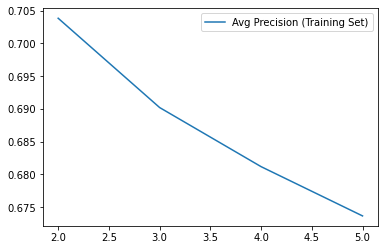

In [153]:
plt.plot(neighb, precision_model, label='Avg Precision (Training Set)')
plt.legend()
plt.show()


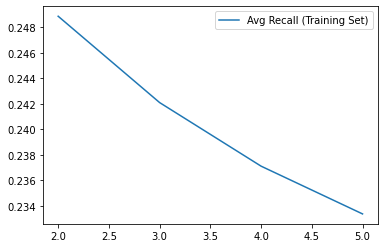

In [154]:
plt.plot(neighb, recall_model, label='Avg Recall (Training Set)')
plt.legend()
plt.show()

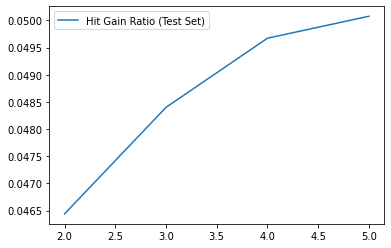

In [155]:
plt.plot(neighb, hgr_model, label='Hit Gain Ratio (Test Set)')
plt.legend()
plt.show()